## Debug: Convective/Stratiform Mask Output for 3D Reflectivity from derived dBZ of WRF Simulations. 

**Fix the CS mask module using 20051025 Hurricane Wilma case.**

**Output the Convective/Stratiform (C/S) Mask information to CONUS dBZ data.**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211217**

In [3]:
import sys
# from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
# from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
# from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
#                  cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

# import conv_stra_sep as cs_sep

modules_path = '/glade/work/hungjui/Research_Test/WRF_dBZ_Cloud_Classification/WRF_dBZ_Class_CONUS1/Modules'
if ( modules_path not in sys.path ):
    sys.path = [modules_path] + sys.path
    # print(sys.path)
    
import conv_stra_mask as csm

**Set input files paths and names:**

In [4]:
def set_input_names(file_date):

    file_path_1_conus = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + '/20051025'# file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       # , Z = file_path_1 
                       #     + file_path_2 
                       #     + file_path_3 
                       #     + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

**Function: Convective/Stratiform separation:**

In [5]:
def CS_separation(refl, lat, lon):

    ## Make sure the array for the masking is in numpy array format (speed issue):
    # refl = dbz_sigmalev.data
    # lat = np.array(dbz_sigmalev.XLAT)
    # lon = np.array(dbz_sigmalev.XLONG)

    # start = time.time()

    ## Convective/Stratiform separation:
    cs, cc, bkgnd = csm.conv_stra_sep(refl, lat, lon, 4, 'L', 'SHY')

    # end = time.time()
    # print("RUNTIME：%f SEC" % (end - start))
    # print("RUNTIME：%f MIN" % ((end - start)/60))
    # print("RUNTIME：%f HOUR" % ((end - start)/3600))
    
    cs[np.where(refl <= 0.0)] = np.nan
    cs[np.where(np.isnan(refl))] = -1
    
    return cs


### Main Testing:

In [6]:
start = time.time()

## WRF Model Simulation Category:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Loop through a period:
# target_date_range = pd.date_range(start='2005-10-25', end='2005-10-25', tz=pytz.utc)

dayi = dt.datetime(2005, 10, 25, 0, 0, 0, tzinfo=pytz.utc)

## Set input files paths and names:
file_name_dict = set_input_names(dayi)

## Open dBZ data array and append calculated data:
ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])
a
## Get dBZ data:
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=0)

## Get dBZ data at specified sigma level:
dbz_sigmalev = da_wrf_dbz[12,:,:]

## Convective/Stratiform Separation:
## !!! Make sure the array for the masking is in numpy array format (speed issue) !!!
CS_mask_single = CS_separation( dbz_sigmalev.data
                              , dbz_sigmalev.XLAT.data
                              , dbz_sigmalev.XLONG.data
                              )

CS_mask = CS_mask_single

ds_wrf_dbz['CS_mask'] = (['south_north', 'west_east'], CS_mask)
ds_wrf_dbz.close()

end = time.time()

print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))
    

NameError: name 'a' is not defined

In [16]:
ds_wrf_dbz

<xarray.Dataset>
Dimensions:         (Time: 8, bottom_top: 50, south_north: 1015, west_east: 1359)
Coordinates:
  * Time            (Time) datetime64[ns] 2005-10-25 ... 2005-10-25T21:00:00
    XLAT            (south_north, west_east) float32 18.14 18.15 ... 52.43 52.42
    XLONG           (south_north, west_east) float32 -122.9 -122.8 ... -56.95
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) |S19 b'2005-10-25_00:00:00' ... b'2005-10-25_21:00...
    XTIME           (Time) float32 2.664e+06 2.664e+06 ... 2.665e+06 2.665e+06
    dBZ             (Time, bottom_top, south_north, west_east) float32 ...
    CS_mask         (Time, south_north, west_east) float64 nan nan ... nan nan
    Storm_Mode_mod  (Time, south_north, west_east) int64 ...
    Storm_Mode_str  (Time, south_north, west_east) int64 ...
Attributes:
    SIMULATION_START_DATE:           2000-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1360
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              4000.0
    DY:                              4000.0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      28
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               11
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  1
    CU_PHYSICS:                      0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       2
    GFDDA_INTERVAL_M:                360
    GFDDA_END_H:                     999999
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    SF_URBAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        0
    SMOOTH_OPTION:                   2
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       1
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    FGDT:                            0.0
    GUV:                             5e-05
    GT:                              5e-05
    GPH:                             5e-05
    IF_RAMPING:                      1
    DTRAMP_MIN:                      60.0
    OBS_NUDGE_OPT:                   0
    BUCKET_MM:                       100.0
    BUCKET_J:                        1000000000.0
    PREC_ACC_DT:                     60.0
    OMLCALL:                         0
    ISFTCFLX:                        0
    ISHALLOW:                        0
    OPT_SFC:                         1
    DVEG:                            4
    OPT_CRS:                         1
    OPT_BTR:                         2
    OPT_RUN:                         1
    OPT_FRZ:                         1
    OPT_INF:                         1
    OPT_RAD:                         3
    OPT_ALB:                         2
    OPT_SNF:                         4
    OPT_TBOT:                        1
    OPT_STC:                         1
    DFI_OPT:                         0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      1359
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_END_STAG:        1360
    SOUTH-NORTH_PATCH_START_UNSTAG:  1
    SOUTH-NORTH_PATCH_END_UNSTAG:    1015
    SOUTH-NORTH_PATCH_START_STAG:    1
    SOUTH-NORTH_PATCH_END_STAG:      1016
    BOTTOM-TOP_PATCH_START_UNSTAG:   1
    BOTTOM-TOP_PATCH_END_UNSTAG:     50
    BOTTOM-TOP_

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


<font color='teal'>**Supplement Codes:**</font>

**Function: creating new map:**

In [18]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    # ax.set_extent([-96, -84, 33, 41], crs=proj)
    ## Test:
    # ax.set_extent([-86, -76, 25, 33], crs=proj)
    # ax.set_extent([-86, -65, 25, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 5
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot:**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


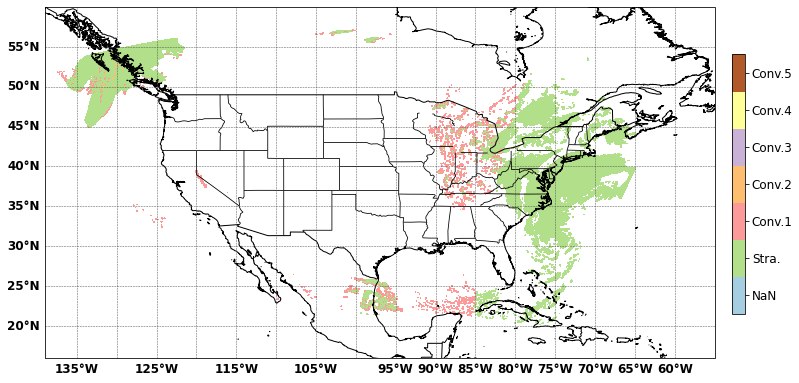

In [20]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

# cs[cs<0] = np.nan
# cc[cc<0] = np.nan

# plotting_var = cs
plotting_var = ds_wrf_dbz.CS_mask[0]
plotting_lon = ds_wrf_dbz.XLONG
plotting_lat = ds_wrf_dbz.XLAT

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=plt.cm.get_cmap('Paired', 7)
                    , vmin=-1
                    , vmax=5
                    , shading='auto'
                    )
cf1.cmap.set_under('w')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(-1, 6, 1), 
                    boundaries=np.arange(-1.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['NaN', 'Stra.', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5'])
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)
